In [1]:
import warnings

import matplotlib.pyplot
import numpy
import torch
import torchinfo
import torchvision
import tqdm.notebook


warnings.filterwarnings('ignore', category=UserWarning) 

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
input_size = (32, 32)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transform,
    download=True,
)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|█████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 41320926.41it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 231174988.21it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 34768073.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|███████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 27529665.85it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Training samples: 60000
Test samples: 10000


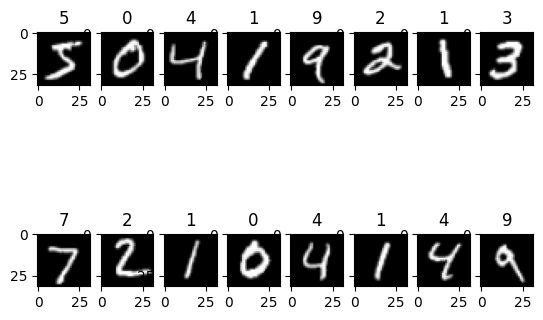

In [3]:
train_images, train_targets = next(iter(train_data_loader))
test_images, test_targets = next(iter(test_data_loader))

fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=len(train_images))

for train_image, train_target, ax in zip(train_images, train_targets, axes[0]):
    ax.set_title(train_target.item())
    
    ax.imshow(train_image.permute(1, 2, 0), cmap='gray')

for test_image, test_target, ax in zip(test_images, test_targets, axes[1]):
    ax.set_title(test_target.item())
    
    ax.imshow(test_image.permute(1, 2, 0), cmap='gray')

matplotlib.pyplot.show()

In [4]:
input_shape = torch.Size(
    [train_data_loader.batch_size, 1, *input_size]
)


class LeNet5(torch.nn.Module):
    """LeNet-5 network module.
    
    Implementation of the LeNet-5 architecture as described by Yann LeCun,
    Léon Bottou, Yoshua Bengio and Patrick Haffner in "Gradient-based learning
    applied to document recognition" (1998).
    """

    def __init__(self):
        super().__init__()
        
        self.feature_extractor = torch.nn.Sequential(            
            torch.nn.Conv2d(1, 6, 5),
            torch.nn.Sigmoid(),
            torch.nn.AvgPool2d(2, 2),
            torch.nn.Conv2d(6, 16, 5),
            torch.nn.Sigmoid(),
            torch.nn.AvgPool2d(2, 2),
            torch.nn.Conv2d(16, 120, 5),
            torch.nn.Sigmoid(),
            torch.nn.Flatten()
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(120, 84),
            torch.nn.Sigmoid(),
            torch.nn.Linear(84, 10),
        )

    def forward(self, inputs):
        features = self.feature_extractor(inputs)

        return self.classifier(features)


model = LeNet5().to(device)

torchinfo.summary(model, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 120]                  --
│    └─Conv2d: 2-1                       [8, 6, 28, 28]            156
│    └─Sigmoid: 2-2                      [8, 6, 28, 28]            --
│    └─AvgPool2d: 2-3                    [8, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [8, 16, 10, 10]           2,416
│    └─Sigmoid: 2-5                      [8, 16, 10, 10]           --
│    └─AvgPool2d: 2-6                    [8, 16, 5, 5]             --
│    └─Conv2d: 2-7                       [8, 120, 1, 1]            48,120
│    └─Sigmoid: 2-8                      [8, 120, 1, 1]            --
│    └─Flatten: 2-9                      [8, 120]                  --
├─Sequential: 1-2                        [8, 10]                   --
│    └─Linear: 2-10                      [8, 84]                   10,164
│  

In [5]:
def train_batch(data_loader, model, criterion, optimizer):
    losses = []
    for inputs, targets in tqdm.notebook.tqdm(
        data_loader,
        leave=False,
        desc='Train',
    ):
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item())
        
    return losses

In [6]:
def test_batch(data_loader, model, criterion):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for inputs, targets in tqdm.notebook.tqdm(
            data_loader,
            leave=False,
            desc='Test',
        ):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            
            predictions = outputs.softmax(1).max(1).indices
            
            correct_predictions += (predictions == targets).int().sum().item()

            loss = criterion(outputs, targets)
            
            losses.append(loss.item())
            
    accuracy = correct_predictions / (data_loader.batch_size * len(data_loader))
            
    return losses, accuracy

In [7]:
def train_and_test(num_epochs, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in tqdm.notebook.tqdm(range(num_epochs), desc='Epoch'):
        epoch_train_losses = train_batch(train_data_loader, model, criterion, optimizer)
        epoch_test_losses, epoch_test_accuracy = test_batch(test_data_loader, model, criterion)

        train_losses.append(epoch_train_losses)
        test_losses.append(epoch_test_losses)
        test_accuracies.append(epoch_test_accuracy)
        
    return train_losses, test_losses, test_accuracies

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Test:   0%|          | 0/1250 [00:00<?, ?it/s]

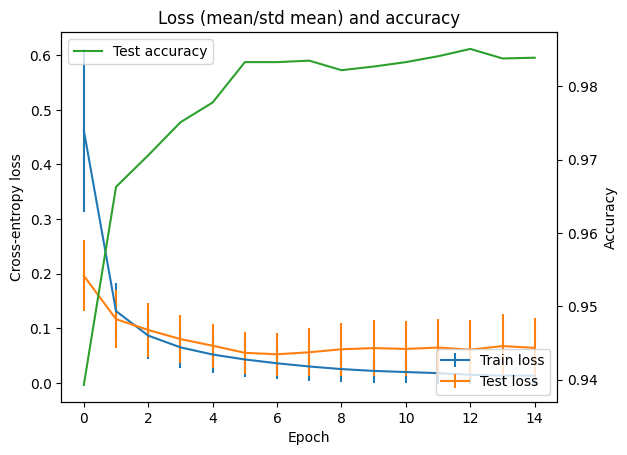

In [8]:
num_epochs = 15

train_losses, test_losses, test_accuracies = train_and_test(num_epochs, model)

fig, loss_ax = matplotlib.pyplot.subplots()

train_mean_loss = [numpy.mean(loss) for loss in train_losses]
train_stdmean_loss = [numpy.std(loss)/numpy.sqrt(len(train_losses)) for loss in train_losses]
test_mean_loss = [numpy.mean(loss) for loss in test_losses]
test_stdmean_loss = [numpy.std(loss)/numpy.sqrt(len(test_losses)) for loss in test_losses]

loss_ax.errorbar(
    x=range(len(train_losses)),
    y=train_mean_loss,
    yerr=train_stdmean_loss,
    label=f'Train loss',
)

loss_ax.errorbar(
    x=range(len(test_losses)),
    y=test_mean_loss,
    yerr=test_stdmean_loss,
    label=f'Test loss',
)

loss_ax.set_title('Loss (mean/std mean) and accuracy')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Cross-entropy loss')
loss_ax.legend(loc='lower right')

accuracy_ax = loss_ax.twinx()

accuracy_ax.plot(test_accuracies, color='tab:green', label=f'Test accuracy')

accuracy_ax.set_ylabel('Accuracy')
accuracy_ax.legend(loc='upper left')

matplotlib.pyplot.show()

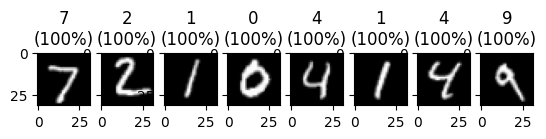

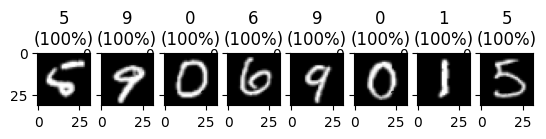

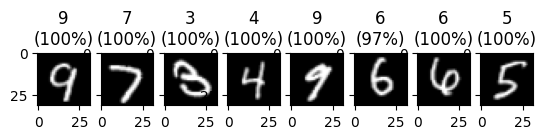

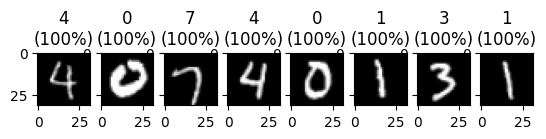

In [9]:
for index, (images, targets) in enumerate(test_data_loader):
    fig, axes = matplotlib.pyplot.subplots(ncols=len(images))

    with torch.no_grad():
        logits = model(images.to(device))

    probabilities = logits.softmax(1).max(1)

    scores, outputs = probabilities.values, probabilities.indices

    for image, output, score, ax in zip(images, outputs, scores, axes):
        ax.set_title(f'{output.item()}\n({score.item():.0%})')

        ax.imshow(image.permute(1, 2, 0), cmap='gray')

    matplotlib.pyplot.show()
    
    if index == 3:
        break